## Problem 1

In [81]:
# All functions from hw5 that will be used
import math
import matplotlib.pyplot as plt
import numpy
import random
import time

dims = 3

def norm(vec):
    ret = 0
    for coord in vec:
        ret += (coord ** 2)
    return math.sqrt(ret)

def compute_energy(r_atoms):
    '''
    r_atoms: list of the location of atoms
    '''
    D = 1
    r_e = 1
    a = 1
    
    energy = 0
    num_atoms = len(r_atoms)
    for i in range(num_atoms):
        for j in range(i+1, num_atoms):
            vec = [r_atoms[i][k] - r_atoms[j][k] for k in range(dims)]
            # We prevent overflow on r the norm because r - r_e is sufficiently large, then
            # our exponent goes to 0
            est_r = False
            for coord in vec:
                if abs(coord) - r_e > 10 / a:
                    est_r = True
            if est_r:
                energy += D
            else:
                r = norm(vec)
                energy += D * ((1 - math.exp(-a * (r - r_e))) ** 2)
    return energy

def center_of_mass(r_atoms):
    num_atoms = len(r_atoms)
    center_mass = [0 for _ in range(dims)]
    for r in r_atoms:
        for j in range(dims):
            center_mass[j] += r[j]
    center_mass = list(map(lambda x: x / num_atoms, center_mass))
    return center_mass

def metropolis_sampling(r_atoms, kT, num_iter, output = True):
    '''
    r_atoms --- intial position of atoms, passed in as a list of coordinates, arbitrarily number of atoms allowed
    kT --- temperature
    num_iter --- number of iterations to run
    '''
    start = time.time()
    num_atoms = len(r_atoms)
    sigma = 1
    sigma_accept_multiplier = 1.01
    sigma_reject_multiplier = 0.99
    beta = 1 / kT
    energy = compute_energy(r_atoms)
    num_accept = 0

    r_list = [None] * num_iter
    energy_list = [None] * num_iter
    cm_list = [None] * num_iter
    accept_list = [None] * num_iter

    for i in range(num_iter):
        # Propose a new position for each atom
        new_r_atoms = []
        for r in r_atoms:
            z = [numpy.random.normal(0, 1), numpy.random.normal(0, 1), numpy.random.normal(0, 1)]
            # Scale by sigma
            z = list(map(lambda x: x * sigma, z))
            new_r = [r[j] - z[j] for j in range(dims)]
            new_r_atoms.append(new_r)
        # Calculate acceptance probability
        new_energy = compute_energy(new_r_atoms)
        # Metropolis
        A = min(1, math.exp(- beta * (new_energy - energy)))
        # Accept
        if A > random.uniform(0, 1):
            num_accept += 1
            # We want to keep accepting higher sigma
            sigma *= sigma_accept_multiplier
            accept_list[i] = True
            # Update position and energy
            r_atoms = new_r_atoms
            energy = new_energy
            # Recenter center of mass to origin
            center_mass = center_of_mass(r_atoms)
            for atom_num in range(num_atoms):
                r_atoms[atom_num] = [r_atoms[atom_num][j] - center_mass[j] for j in range(3)]
        # Reject
        else:
            sigma *= sigma_reject_multiplier
            accept_list[i] = False

        r_list[i] = r_atoms
        energy_list[i] = energy
        cm_list[i] = center_of_mass(r_atoms)

    if output:
        print(f"Finished running simulation with kT = {kT}, # iterations = {num_iter}")
        print(f"Simulation time: {round(time.time() - start, 3)}s")
        print(f"Accept ratio: {round(num_accept / num_iter, 4)}")
    return r_list, energy_list

def autocorrelation(data, lag):
    num_samples = len(data)
    autocorr = 0
    for j in range(num_samples - lag):
        autocorr += (data[j] * data[j + lag])
    autocorr /= (num_samples - lag)
    return autocorr

def plot_autocorrelation(data, max_lag, title, col):
    lags = numpy.asarray(range(1, max_lag + 1))
    autocorrs = []
    for lag in lags:
        autocorrs.append(autocorrelation(data, lag))

    plt.plot(lags, autocorrs, color = col, label = "Data")
    plt.title(title)
    plt.xlabel("Lag")
    plt.ylabel("Autocorrelation")
    plt.show()

### (e)

In [82]:
r_atoms = [
    [0, 0, 0],
    [0, 0, 1],
    [0, 1, 0],
    [0, 1, 1],
    [1, 0, 0],
    [1, 0, 1],
    [1, 1, 0],
    [1, 1, 1]
]
num_atoms = len(r_atoms)
walk_length = 10 ** 5

First I estimate the correlation time of energy for each of my low temperatures: $kT = \frac{1}{5}, \frac{1}{5^2}, \frac{1}{5^3}, \frac{1}{5^4}$ by eyeballing the auutocorrelation charts:

Finished running simulation with kT = 0.2, # iterations = 100000
Simulation time: 20.125s
Accept ratio: 0.5011


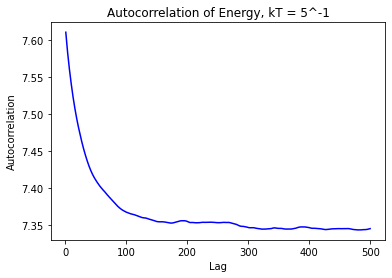

Finished running simulation with kT = 0.04, # iterations = 100000
Simulation time: 18.266s
Accept ratio: 0.5007


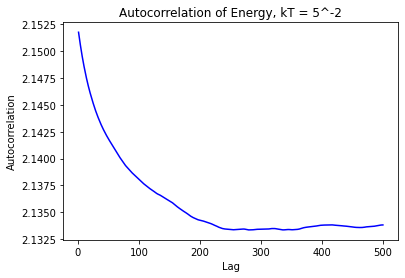

Finished running simulation with kT = 0.008, # iterations = 100000
Simulation time: 19.295s
Accept ratio: 0.5003


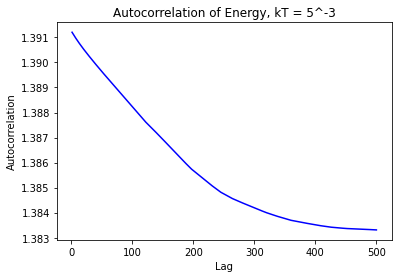

Finished running simulation with kT = 0.0016, # iterations = 100000
Simulation time: 18.901s
Accept ratio: 0.4999


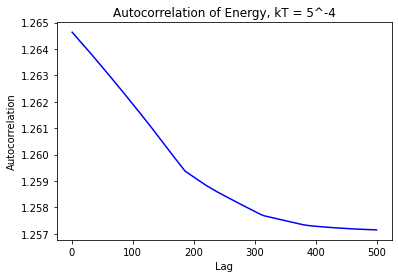

In [83]:
results = {}

for i in range(-1, -5, -1):
    temp = 5 ** i
    r_list, energy_list = metropolis_sampling(r_atoms, temp, walk_length)
    results[temp] = [r_list, energy_list]
    #first_atom_x = []
    #for j in range(walk_length):
    #    first_atom_x.append(r_list[j][0][0])
    plot_autocorrelation(energy_list, 500, f"Autocorrelation of Energy, kT = 5^{i}", "blue")


I pick $kT = \frac{1}{5^3}$ with correlation time $\tau = 350$ to investigate the 5 lowest energy structures of further.

Five lowest energy structures for kT = 0.0016


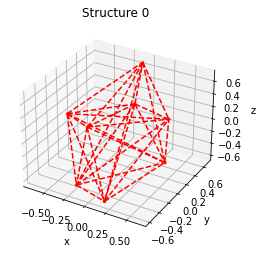

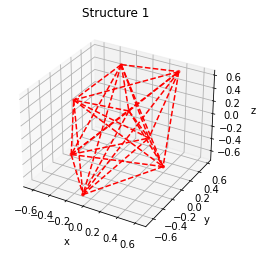

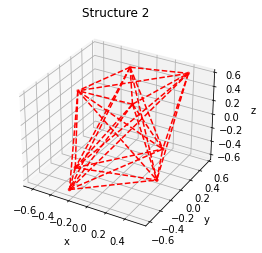

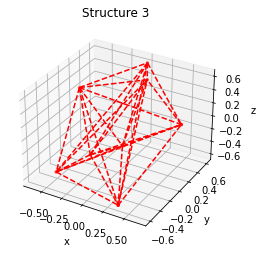

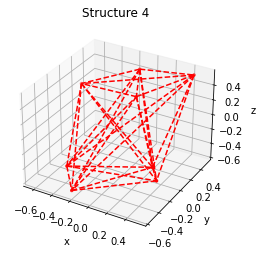

In [84]:
# Estimates using plots above
correlation_time = {
    5 ** -1: 150,
    5 ** -2: 200,
    5 ** -3: 350,
    5 ** -4: 350
}

temp = 5 ** -4
tau = correlation_time[temp]

r_list = results[temp][0]
energy_list = results[temp][1]

# Attach walk number to energy
decorrelated_energy = list(enumerate(energy_list))[tau:walk_length:tau]
# Sort by energy
decorrelated_energy.sort(key = lambda x: x[1])
# Find the walk numbers with the lowest energy
lowest_indices = list(map(lambda x: x[0], decorrelated_energy[:5]))
# Find the structures associatted with these lowest indices
lowest_structures = []
for idx in lowest_indices:
    lowest_structures.append(r_list[idx])
#print(lowest_indices)

print(f"Five lowest energy structures for kT = {temp}")
for i in range(len(lowest_structures)):
    structure = lowest_structures[i]
    m = numpy.matrix(structure)
    
    fig = plt.figure()
    ax = fig.add_subplot(projection = "3d")
    x = m[:,0]
    y = m[:,1]
    z = m[:,1]
    ax.scatter(x, y, z, marker = ".", s = 25, c = "red")
    ax.set_title(f"Structure {i}")
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    
    for j in range(num_atoms):
        for k in range(j+1, num_atoms):
            ax.plot3D([x[j, 0], x[k, 0]], [y[j, 0], y[k, 0]], [z[j, 0], z[k, 0]], c = "red", ls = "--")
    plt.show()    

I can tell from my plots that the atoms are clustered around the origin and positioned rather equidistantly from each other with very few of them being close together. This matches up with what we know which is that the lowest energy $V(r)$ occurs when the atoms are all distance 1 from each other.

### (f)

In [85]:
num_iter = 10 ** 5
num_steps = 8
e_bars = [0] * (num_steps + 1)
est_sigmas = [0] * (num_steps + 1)

for i in range(1, num_steps + 1):
    kT = 0.05 * i
    _, energy_list = metropolis_sampling(r_atoms, kT, num_iter, output = False)
    e_bar = sum(energy_list) / num_iter
    est_sigma = 0
    for e in energy_list:
        est_sigma += ((e - e_bar) ** 2)
    est_sigma /= (num_iter - 1)
    est_sigma = math.sqrt(est_sigma)

    e_bars[i] = e_bar
    est_sigmas[i] = est_sigma

kT               Mean of E        Estimated Sigma of E
0.05             1.553259         0.152718        
0.10             1.989960         0.284664        
0.15             2.350464         0.391991        
0.20             2.725409         0.540933        
0.25             3.041143         0.667137        
0.30             3.422098         0.807201        
0.35             3.793909         0.976194        
0.40             4.256968         1.186642        


Text(0, 0.5, '$\\overline{E}$')

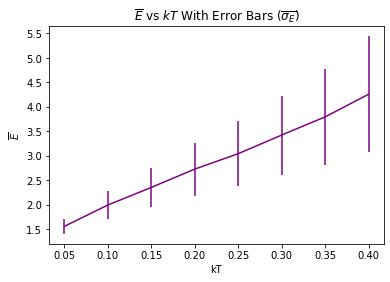

In [86]:
print("{:<16} {:<16} {:<16}".format("kT", "Mean of E", "Estimated Sigma of E"))
for i in range(1, num_steps + 1):
    print("{:<16.2f} {:<16.6f} {:<16.6f}".format(0.05 * i, e_bars[i], est_sigmas[i]))

plt.errorbar([0.05 * j for j in range(1, num_steps+1)], e_bars[1:], yerr = est_sigmas[1:], color = "purple")
plt.title(r"$\overline{E}$ vs $kT$ With Error Bars ($\overline{\sigma_E}$)")
plt.xlabel("kT")
plt.ylabel(r"$\overline{E}$")

It appears that $\overline{E}$ appears to behave quadratically versus $kT$ as we would exppect under the equipartition theorem. We can generally note that when we increase $kT$ by a factor of k = 4, then $\overline{E}$ is increased by a factor of $\sqrt{k} = 2$

### (g)

Finished running simulation with kT = 1, # iterations = 10000
Simulation time: 1.762s
Accept ratio: 0.9783


/Users/jchen/APHY_470/lib/python3.7/site-packages/ipykernel_launcher.py:117: RuntimeWarning: invalid value encountered in long_scalars


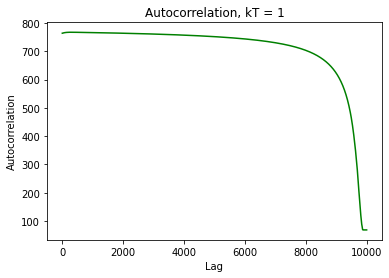

In [94]:
kT = 1

r_list, energy_list = metropolis_sampling(r_atoms, kT, 10 ** 4)
plot_autocorrelation(energy_list, 10 ** 4, f"Autocorrelation, kT = {kT}", "green")

A lot of my data analysis from above cannot be conventionally applied to high temperatures such as $kT = 1$. This is because a high $kT$ leads to too high of an acceptance rate which means that the atoms move too freely, thus increasing their energy from the local minimum. This makes sense physically because with higher temperatures, atoms move around more. As a result, the distance converges as the atoms get very far from each other. This means the atoms no longer cluster together and autocorrelation for energy makes very little sense